In [1]:
#Import Important Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7

In [2]:
#Import Big Mart Sales Modified data set
train = pd.read_csv('train_bigmart_modified.csv')
test = pd.read_csv('test_bigmart_modified.csv')
target = 'Item_Outlet_Sales'

train.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Years,Supermarket Type1,Supermarket Type2,Supermarket Type3,Regular,...,OUT013,OUT017,OUT018,OUT019,OUT027,OUT035,OUT045,OUT046,OUT049,Item_Outlet_Sales
0,9.30,0.016047,249.8092,2,1,14,1,0,0,0,...,0,0,0,0,0,0,0,0,1,3735.1380
1,5.92,0.019278,48.2692,2,3,4,0,1,0,1,...,0,0,1,0,0,0,0,0,0,443.4228
2,17.50,0.016760,141.6180,2,1,14,1,0,0,0,...,0,0,0,0,0,0,0,0,1,2097.2700
3,19.20,0.057851,182.0950,2,3,15,0,0,0,1,...,0,0,0,0,0,0,0,0,0,732.3800
4,8.93,0.057851,53.8614,3,3,26,1,0,0,0,...,1,0,0,0,0,0,0,0,0,994.7052


In [3]:
#Define Model Fit Fuction
def modelfit(alg, dtrain, predictors, useTrainCV = True, cv_fold=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_fold,
                         metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit Algorithm on data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='rmse')
    
    #Predict training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Prin Model Report
    MSE = metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)
    RMSE = np.sqrt(MSE)
    
    print("Model Report")
    print("RMSE: {:.2f}".format(RMSE))
    
    #Feature Contribution
    feature_cols = [x for x in train.columns if x not in [target]]
    feature_imp = pd.Series(alg.feature_importances_, index = feature_cols).sort_values(ascending = False)
    feature_imp

    #Create Bar Plot
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature')
    plt.title('Visualize Important Features by XGBoost Regression')
    plt.show()
    

# Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

[11:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Python\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:26:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/n Model Report
RMSE: 1027.11


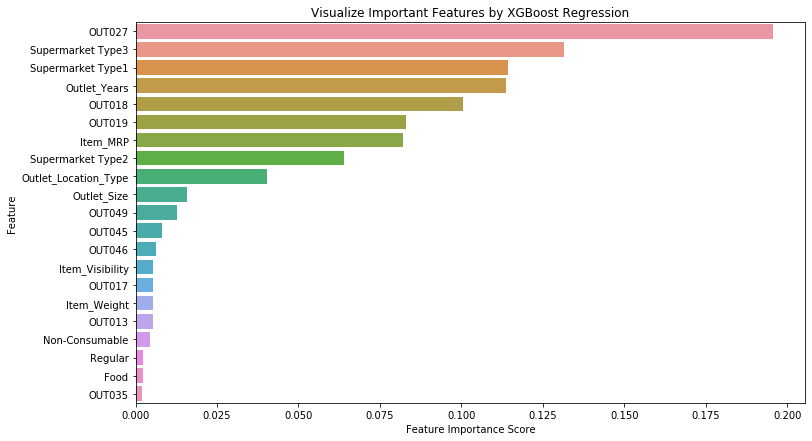

In [30]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=42)

modelfit(xgb1, train, predictors)

In [36]:
xgb1.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 41,
 'n_jobs': 1,
 'nthread': 4,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 42,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1}

# Step 2: Tune max_depth and min_child_weight

In [44]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

#Instantiate XGBRegressor
xgb_reg = XGBRegressor( learning_rate =0.1, n_estimators=41, max_depth=5, min_child_weight=1, 
                       gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=42)

#GridSeachCV with 5 fold using negative MSE for perfomance metrics
gsearch1 = GridSearchCV(xgb_reg , param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=-1, iid=False, cv=5)

#Fit Model with training set
gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_, np.sqrt(np.abs(gsearch1.best_score_))

[13:06:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 5, 'min_child_weight': 3}, 1092.9424008028018)

In [45]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[2,3,4]
}

#Instantiate XGBRegressor
xgb_reg = XGBRegressor( learning_rate =0.1, n_estimators=41, max_depth=5, min_child_weight=1, 
                       gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=42)

#GridSeachCV with 5 fold using negative MSE for perfomance metrics
gsearch2 = GridSearchCV(xgb_reg , param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=-1, iid=False, cv=5)

#Fit Model with training set
gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, np.sqrt(np.abs(gsearch2.best_score_))

[13:10:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 4, 'min_child_weight': 4}, 1090.8139480372113)

In [48]:
param_test2b = {
 'min_child_weight':[4,6,8,10]
}

#Instantiate XGBRegressor
xgb_reg = XGBRegressor( learning_rate =0.1, n_estimators=41, max_depth=4, min_child_weight=1, 
                       gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=42)

#GridSeachCV with 5 fold using negative MSE for perfomance metrics
gsearch2b = GridSearchCV(xgb_reg , param_grid = param_test2b, scoring='neg_mean_squared_error',n_jobs=-1, iid=False, cv=5)

#Fit Model with training set
gsearch2b.fit(train[predictors],train[target])
gsearch2b.best_params_, np.sqrt(np.abs(gsearch2b.best_score_))

[13:16:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'min_child_weight': 10}, 1090.4252189540723)

# Step 3: Tune gamma

In [49]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

#Instantiate XGBRegressor
xgb_reg = XGBRegressor( learning_rate =0.1, n_estimators=41, max_depth=4, min_child_weight=10, 
                       gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=42)

#GridSeachCV with 5 fold using negative MSE for perfomance metrics
gsearch3 = GridSearchCV(xgb_reg , param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1, iid=False, cv=5)

#Fit Model with training set
gsearch3.fit(train[predictors],train[target])
gsearch3.best_params_, np.sqrt(np.abs(gsearch3.best_score_))

[13:16:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'gamma': 0.0}, 1090.4252189540723)

[13:17:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/n Model Report


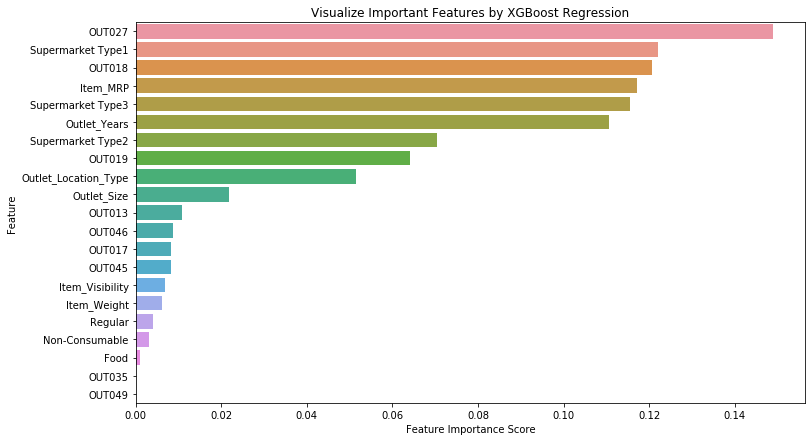

In [50]:
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=10,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=42)
modelfit(xgb2, train, predictors)

In [51]:
xgb2.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 10,
 'missing': None,
 'n_estimators': 46,
 'n_jobs': 1,
 'nthread': 4,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 42,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1}

# Step 4: Tune subsample and colsample_bytree

In [52]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

#Instantiate XGBRegressor
xgb_reg = XGBRegressor( learning_rate =0.1, n_estimators=46, max_depth=4, min_child_weight=10, 
                       gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=42)

#GridSeachCV with 5 fold using negative MSE for perfomance metrics
gsearch4 = GridSearchCV(xgb_reg , param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=-1, iid=False, cv=5)

#Fit Model with training set
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_, np.sqrt(np.abs(gsearch4.best_score_))

D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Python\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:20:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'colsample_bytree': 0.8, 'subsample': 0.7}, 1086.7347760819632)

# Step 5: Tuning Regularization Parameters

In [53]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

#Instantiate XGBRegressor
xgb_reg = XGBRegressor( learning_rate =0.1, n_estimators=46, max_depth=4, min_child_weight=10, 
                       gamma=0, subsample=0.7, colsample_bytree=0.8, objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=42)

#GridSeachCV with 5 fold using negative MSE for perfomance metrics
gsearch5 = GridSearchCV(xgb_reg , param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=-1, iid=False, cv=5)

#Fit Model with training set
gsearch5.fit(train[predictors],train[target])
gsearch5.best_params_, np.sqrt(np.abs(gsearch5.best_score_))

[13:23:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 1}, 1086.5801078996485)

In [54]:
param_test6 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 1, 2]
}

#Instantiate XGBRegressor
xgb_reg = XGBRegressor( learning_rate =0.1, n_estimators=46, max_depth=4, min_child_weight=10, 
                       gamma=0, subsample=0.7, colsample_bytree=0.8, objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=42)

#GridSeachCV with 5 fold using negative MSE for perfomance metrics
gsearch6 = GridSearchCV(xgb_reg , param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=-1, iid=False, cv=5)

#Fit Model with training set
gsearch6.fit(train[predictors],train[target])
gsearch6.best_params_, np.sqrt(np.abs(gsearch6.best_score_))

[13:26:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 1}, 1086.5801078996485)

[13:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/n Model Report


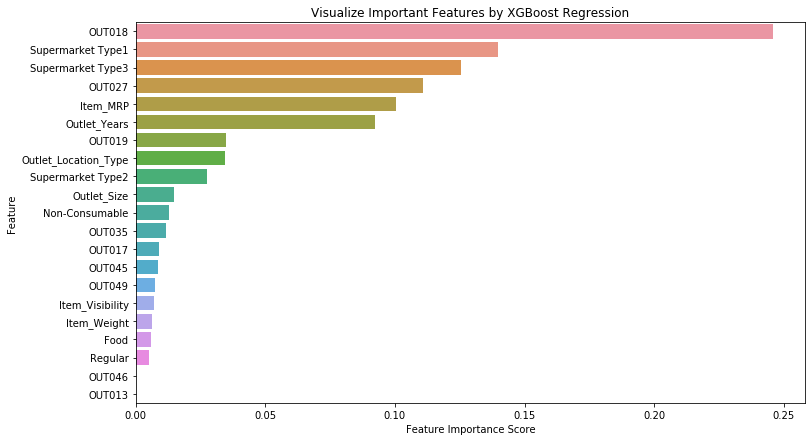

In [55]:
xgb3 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=10,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

# Step 6: Reducing Learning Rate

[13:28:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Python\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:28:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
/n Model Report
RMSE: 1043.86


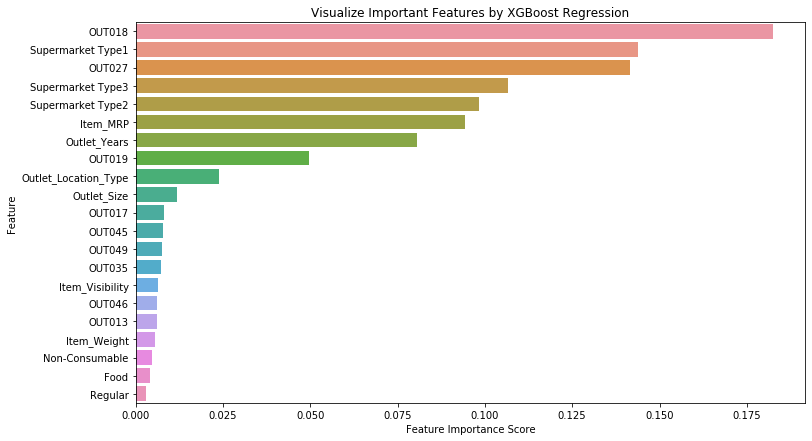

In [56]:
xgb4 = XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=10,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.8,
 reg_alpha=1,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

# Hyper Parameter Tuning All together

In [5]:
#Grid Parameters
grid_params = {'learning_rate': [0.01, 0.05, 0.1, 0.5, 0.2],
               'max_depth':np.arange(5,10,1),
               'min_child_weight': np.arange(1,5,1),
               'reg_alpha':[1e-3, 1e-2, 0.1, 1, 100]}

#Instantiate XGBRegressor
xgb_reg = XGBRegressor(n_estimators=1000,gamma =0, subsample=0.8,colsample_bytree=0.8, objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=42)

#GridSeachCV with 5 fold using negative MSE for perfomance metrics
gsearch7 = GridSearchCV(xgb_reg , param_grid = grid_params, scoring='neg_mean_squared_error',n_jobs=-1, verbose=2, cv=5)

#Fit Model with training set
predictors = [x for x in train.columns if x not in [target]]
gsearch7.fit(train[predictors],train[target])
gsearch7.best_params_, np.sqrt(np.abs(gsearch7.best_score_))


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 52.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 74.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 101.1min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 127.8min finished
D:\Python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Python\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:06:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'learning_rate': 0.01,
  'max_depth': 5,
  'min_child_weight': 4,
  'reg_alpha': 0.001},
 1098.5193959130488)